In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

SEED=42
np.random.seed(SEED)

In [35]:
def sigmoid(x, derivative=False):
        if(derivative):
            return sigmoid(x) * (1 - sigmoid(x))
        
        return 1.0/(1.0 + np.exp(-x))

### Dataset:  MNIST Digit 9

In [36]:
digits = np.load('datasets/digit_9_samples.pkl', allow_pickle=True)
noise  = np.random.random((36, 784))

### Model: Generative Adversarial Network (GAN)

GAN architecture comprises two key components:

1. Generator: This network generates synthetic data from random noise or a latent space. Its goal is to create data that is indistinguishable from real data.

2. Discriminator: This network distinguishes between real and generated data. It provides feedback to the generator to help improve the quality of the generated data.

During training, these networks compete, leading to the refinement of the generator's ability to create realistic data, making GANs a powerful tool for tasks like image generation, style transfer, and data augmentation.

In [38]:
class Discriminator:

    learning_rate = 0.01
    nodes = 784
    np.random.seed(42)

    def __init__(self):
        self.weights = np.array([np.random.normal() for i in range(self.nodes)])
        self.biases = np.random.normal()

    def forward(self, x):
        return sigmoid(np.dot(x, self.weights) + self.biases)
    
    def backward(self, x, dOut, isDigit):
        if isDigit:
            nWeights = -x * (1-dOut)
            nBiases = -(1-dOut)
        else:
            nWeights = x * dOut
            nBiases = dOut
        return nWeights, nBiases

    def fit(self, x, isDigit=False):
        # calculate error
        dOut = self.forward(x)
        if isDigit:
            dError = -np.log(dOut)
        else:
            dError = -np.log(1-dOut)
        # back propagation
        nWeights, nBiases = self.backward(x, dOut, isDigit)
        # update
        self.weights -= self.learning_rate * nWeights
        self.biases -= self.learning_rate * nBiases

        return dError

In [39]:
class Generator:

    learning_rate = 0.01
    nodes = 784
    np.random.seed(42)

    def __init__(self):
        self.weights = np.array([np.random.normal() for i in range(self.nodes)])
        self.biases = np.array([np.random.normal() for i in range(self.nodes)])

    def forward(self, x):
        return sigmoid(x * self.weights + self.biases)
    
    def backward(self, x, gOut, dOut, discriminator):
        factor = -(1-dOut) * discriminator.weights * gOut * (1-gOut)
        return factor * x, factor   

    def fit(self, x, discriminator):   
        # calculate error
        gOut = self.forward(x)
        dOut = discriminator.forward(gOut)
        gError = -np.log(dOut)
        # backpropagate
        nWeights, nBiases = self.backward(x, gOut, dOut, discriminator)
        # update
        self.weights -= self.learning_rate * nWeights
        self.biases -= self.learning_rate * nBiases

        return gError

    def generate(self):
        x = np.random.rand()
        return self.forward(x)
    

### Training

In [40]:
D = Discriminator()
G = Generator()

epochs = 7000
dErrors = []
gErrors = []

In [41]:
for epoch in range(epochs):
    d_error1 , d_error2 , g_error = 0, 0, 0
    for digit in digits:
        d_error1 += D.fit(digit, isDigit=True)
        gOut = G.generate()
        d_error2 = D.fit(gOut)
        g_error += G.fit(gOut, D)

    if (epoch % 100) == 0:
        dErrors.append(((d_error1 + d_error2)/2)/14)
        gErrors.append(g_error/14)

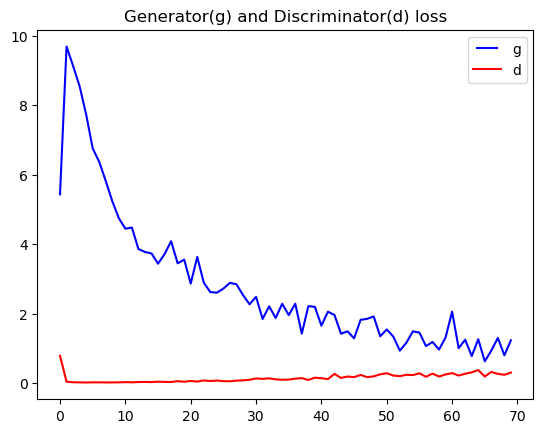

In [42]:
sprt = [i for i in range(epochs//100)] # for x-axis
gPlot, = plt.plot(sprt, gErrors, color='blue', label='g')
dPlot, = plt.plot(sprt, dErrors, color='red', label='d')
plt.legend(handler_map={gPlot: HandlerLine2D(numpoints=4)})
plt.title("Generator(g) and Discriminator(d) loss")
plt.show()

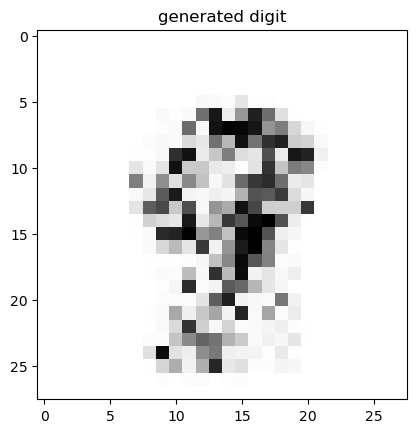

In [43]:
sample = G.generate()
plt.imshow(sample.reshape((28, 28)), cmap='Greys')
plt.title("generated digit")
plt.show()